# Анализ резюме программистов и прогнозирование зарплаты

##  Предварительный анализ

In [1]:
#АНАЛИЗ ДАННЫХ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

#РАБОТА С ТЕКСТОМ
from tqdm import tqdm
import re
from pymystem3 import Mystem
import nltk
from sklearn.feature_extraction.text import CountVectorizer 

#ПОДГОТОВКА ПРИЗНАКОВ
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ПРОГНОЗИРОВАНИЕ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

import optuna
from optuna.distributions import IntDistribution, CategoricalDistribution
from optuna.integration import OptunaSearchCV

In [2]:
data = pd.read_csv('C:/Users/79283/Desktop/cv_programmers.csv', encoding='mbcs')
data.head()

,Unnamed: 0,id,abilympics_inspection_status,abilympics_participation,worldskills_inspection_status,state_region_code,regionNameTerm,position_name,date_create,date_modify,...,workExperienceList,educationList,additionalEducationList,desirableRelocationRegions,contactList,worldskills,languageKnowledge,hardSkills,softSkills,localityName
0,44,02f70fc0-5142-11ec-b050-1b29d3b53cbb,UNKNOWN,False,NOT_APPLICABLE,6100000000000,NaN,Техник-программист,2021-11-29T21:27:30+0300,2021-11-29T21:29:16+0300,...,"[{""company_name"": ""Индивидуальный предпринимат...","[{""diploma_name"": ""Проектирование и разработка...",[],[],"[{""contact_type"": ""Эл. почта"", ""is_moderated"":...",[],"[{""code_language"": ""Английский"", ""level"": ""Чте...",[],[],"Ростовская-область,-г.-Ростов-на-Дону"
1,54,02f6df20-3b3d-11ec-a60c-839f0d9a4379,UNKNOWN,False,NOT_APPLICABLE,7800000000000,NaN,Программист,2021-11-01T20:56:17+0300,2021-11-28T19:12:25+0300,...,"[{""company_name"": ""Corbina Telecom"", ""date_fro...","[{""graduate_year"": 1995, ""institute_name"": ""Шк...",[],[],"[{""contact_type"": ""Эл. почта"", ""is_moderated"":...",[],"[{""code_language"": ""Русский"", ""level"": ""Родной...",[],[],г.-Санкт-Петербург
2,294,02efefb0-0e43-11ed-81ab-7fb917d16256,UNKNOWN,False,NOT_APPLICABLE,5600000000000,NaN,Программист,2022-07-28T10:00:49+0300,2022-07-29T10:30:56+0300,...,"[{""company_name"": ""КФКСТ и МП г. Медногорска"",...","[{""graduate_year"": 2020, ""institute_name"": ""мб...",[],[],"[{""contact_type"": ""Эл. почта"", ""is_moderated"":...",[],"[{""code_language"": ""Французский"", ""level"": ""Ба...","[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...","Оренбургская-область,-г.-Медногорск"
3,415,02ec5b90-658a-11ed-8193-e57b87a63fa7,UNKNOWN,False,NOT_APPLICABLE,1600000000000,NaN,Программист,2022-11-16T11:38:14+0300,2022-11-16T11:38:14+0300,...,[],"[{""owner_id"": ""02ec5b90-658a-11ed-8193-e57b87a...",[],[],"[{""contact_type"": ""Эл. почта"", ""is_moderated"":...",[],[],[],[],"Республика-Татарстан,-г.-Казань"
4,689,029ebe60-e0d0-11ec-a466-839f0d9a4379,UNKNOWN,False,NOT_APPLICABLE,5700000000000,NaN,Техник-программист,2022-05-31T13:54:14+0300,2022-05-31T13:56:04+0300,...,[],"[{""diploma_name"": ""Разработка системы дистанци...",[],[],"[{""contact_type"": ""Эл. почта"", ""is_moderated"":...",[],"[{""code_language"": ""Русский"", ""level"": ""Родной...","[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...","Орловская-область,-г.-Новосиль"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     425 non-null    int64  
 1   id                             425 non-null    object 
 2   abilympics_inspection_status   425 non-null    object 
 3   abilympics_participation       425 non-null    bool   
 4   worldskills_inspection_status  425 non-null    object 
 5   state_region_code              425 non-null    int64  
 6   regionNameTerm                 0 non-null      float64
 7   position_name                  425 non-null    object 
 8   date_create                    425 non-null    object 
 9   date_modify                    425 non-null    object 
 10  home_city_code                 425 non-null    int64  
 11  education                      367 non-null    object 
 12  academic_degree                0 non-null      flo

Таблица содержит информацию из резюме программистов. На первый взгляд, таблица содержит следующие ошибки:
* пропуски
* пропуски в виде '[]'

Задачи которые необходимо выполнить:
1. Провести очистку данных. Этап будет включать в себя следующие подзадачи:
    - Принять меры по работе с пропусками, типами данных. 
    - Рассмотреть уникальные значения, распределения значений столбцов и избавиться от наименее информативных.
2. Подготовить данные для обучения. Этап будет включать в себя следующие подзадачи:
    - Провести кодировку категориальных признаков.
    - Преобразовать некоторые признаки и создать новые.
    - Правильно представить отображение значений-списков.
    - Провести стандартизацию значений.
    - Подготовить обучающую и тестовую выборки.
3. Обучение моделей.
    - Определить метрики, на которые будем ориентироваться.
    - Определить несколько моделей, которые будем использовать.
    - Подобрать гиперпараметры.
    - Обучить модель о оценить качество.
4. Тестирование.
    - Провести тестирование
    - Сформулировать выводы

В ходе работы, нам необходимо исследовать данные и подготовить их для прогнозирования желаемой зарплаты (столбец **salary**).

Для удобства, создадим копию таблицы, на которой будем проводить первичный анализ:

In [4]:
df = data.copy()

In [5]:
#функция по очистке предложений от символов и английских слов
def clean_text(text, language):
    if language == 'russian':
        text = ' '.join(re.sub(r'[^а-яА-яёЁ]', ' ', text).split())
    elif language == 'english':
        text = ' '.join(re.sub(r'[^a-zA-z]', ' ', text).split())
        
    return text

#лемматизация предложений
def lemmatize_text(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
        
    return lemm_text

Функция ниже использовалась в дальнейшем для ознакомления содержания в текстовых столбцах, но не для принятия решений.

In [6]:
# #функция нахождения частоты употребляемых слов в столбце
#
# def find_top_words(series, language, limit=-1):
#     #CountVectorizer можно использовать для оценки важности каждого слова или словосочетания, но в этом коде он нужен чтобы 
#     #определить самые встречаемые слова
#     corpus = series.copy().dropna()
#     corpus = [clean_text(text, language) for text in corpus]
#     corpus = [lemmatize_text(text) for text in tqdm(corpus)]
    
#     stopwords = nltk.corpus.stopwords.words(language)
#     newStopwords = ['type', 'owner', 'id', 'language', 'languageknowledge', 'level', 'code', 'hard', 'skill', 'name',
#                    'soft', 'graduate', 'year', 'organization', 'diploma', 'faculty', 'institute',
#                    'qualification', 'speaciality', 'hard_skill_name', 'soft_skill_name', 'company_name',
#                     'code_profession', 'code_professional_sphere', ''
#                    ]
#     stopwords.extend(newStopwords)
#     count_vect = CountVectorizer(stop_words=stopwords)
#     corpus = np.array(corpus).astype('U')
#     bow = count_vect.fit_transform(corpus)

#     #сложив все строки матрицы bow мы получим частоту встречаемости каждого слова во всем столбце вцелом
#     count = np.zeros(bow.shape[1])
#     for i in range(bow.shape[0]):
#         count += bow[i,:]

#     #вывод информации
#     top = pd.DataFrame({'name':count_vect.get_feature_names_out(),
#                       'val': list(np.array(count).reshape(-1,))})
#     display(top.sort_values(by='val', ascending=False)[:limit])

### Уникальные значения

Во первых, столбцы *Unnamed: 0* и *id*, так как они не несут в себе никакой информации. Прежде чем удалить их, убедимся в том, что в таблице каждый id уникален.

In [7]:
df['id'].duplicated().sum()

0

In [8]:
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

Прежде чем перейти к пропускам, рассмотрим уникальные значения столбцов. В предварительном анализе мы выявили значения '[]' - нужно понять чем они являются. Чтобы оценить эти значения, выведем по каждому столбцу уникальные значения (кроме 'Unnamed: 0' и 'id') и их встречаемость методом `value_counts()`

In [9]:
for column in df.columns:
    print(f'{column.upper()} \n')
    print(df[column].value_counts())
    print('='*30)

ABILYMPICS_INSPECTION_STATUS 

UNKNOWN    425
Name: abilympics_inspection_status, dtype: int64
ABILYMPICS_PARTICIPATION 

False    423
True       2
Name: abilympics_participation, dtype: int64
WORLDSKILLS_INSPECTION_STATUS 

NOT_APPLICABLE    421
WAITING             4
Name: worldskills_inspection_status, dtype: int64
STATE_REGION_CODE 

7800000000000    21
2300000000000    18
200000000000     16
6300000000000    15
6600000000000    14
                 ..
6900000000000     1
3500000000000     1
1100000000000     1
1300000000000     1
300000000000      1
Name: state_region_code, Length: 70, dtype: int64
REGIONNAMETERM 

Series([], Name: regionNameTerm, dtype: int64)
POSITION_NAME 

Программист                                                                 184
программист                                                                  45
Инженер-программист                                                          20
Техник-программист                                                     

Мы удалим те столбцы, в которых присутствуют следующие признаки:
1. Какое то одно значение встречается больше чем в 99% случаев
2. Каждое значение в столбце уникально и не является списком или предложением

От этих столбцов модели не будет пользы.

Во всех столбцах '[]' обозначали пропуски, в некоторых случаях их было настолько много, что они попадут под первый признак столбцов, которые мы удалим.

In [10]:
useless_columns = ['abilympics_inspection_status', 'abilympics_participation', 'worldskills_inspection_status', 
                  'regionNameTerm', 'position_name', 'date_create', 'date_modify', 'home_city_code', 'academic_degree',
                  'code_country', 'nark_inspection_status', 'nark_certificate', 'published_date', 'id_candidate',
                  'other_info', 'id_user', 'publication_period', 'rf_citizen', 'status', 'visibility', 'code_external_system',
                  'deleted', 'desirableRelocationRegions', 'contactList', 'worldskills']

In [11]:
df.drop(useless_columns, axis=1, inplace=True)
df = df.replace('[]', None)

У нас есть два похожих столбца - **state_region_code** и **localityName**. Из них мы оставим лишь второй, так как он имеет реальные названия городов, мы сможем вычленить из этого больше информации на дальнейших этапах анализа.

In [12]:
df.drop(['state_region_code'], axis=1, inplace=True)

Также у нас есть **schedule_type** и **busy_type**, в них информация и графике работы, который предпочитает соискатель. Первый содержит список, второй содержит одно - по всей видимости наиболее желанный вариант для соискателя. Поэтому мы оставим именно второй столбец.

In [13]:
df.drop(['schedule_type'], axis=1, inplace=True)

### Распределения численных столбцов

Таблицу `df` мы будем использовать для обучения модели, поэтому нам необходимо удалить выбросы из данных.

Мы рассмотрим численные столбцы: *salary, experience, fullness_rate*. Наша задача в этом пункте удалить строки в которых будут артефакты. Сперва рассмотрим наш целевой признак - *salary*. 

In [14]:
def get_histplot(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    outlier_high = df[column].quantile(0.75) + 1.5*iqr
    outlier_low = df[column].quantile(0.25) - 1.5*iqr

    plt.title(f'{column.title()} Histogram')
    sns.histplot(data=df[column], color='#5996fc', edgecolor='#5996fc')
    plt.grid(linestyle='--')
    plt.axvline(x=outlier_high, color='red', linestyle='--')
    plt.axvline(x=outlier_low, color='red', linestyle='--')
    plt.axvline(x=df[column].quantile(0.95), color='green', linestyle='--')
    plt.axvline(x=df[column].quantile(0.05), color='green', linestyle='--')
    
    plt.show()

#### 1. Столбец salary

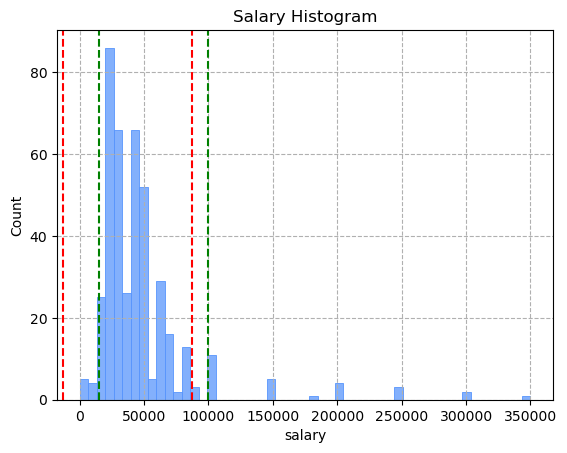

In [15]:
get_histplot(df, 'salary')

In [16]:
df.describe()['salary']

count       425.000000
mean      46426.835294
std       40432.473215
min           0.000000
25%       25000.000000
50%       40000.000000
75%       50000.000000
max      350000.000000
Name: salary, dtype: float64

1. Средняя заработная плата составляет 46500 рублей.
2. Основной диапазон зарплат от 20000 до 100000 рублей.

Красная линия разделяет область 'нормальных' значений от слишком больших, а зеленая линия указывает на редкие значения (95% и 5% квантили). Эти линии просто будут служить ориентиром в принятии решений об удалении строк.

<AxesSubplot:xlabel='salary', ylabel='Count'>

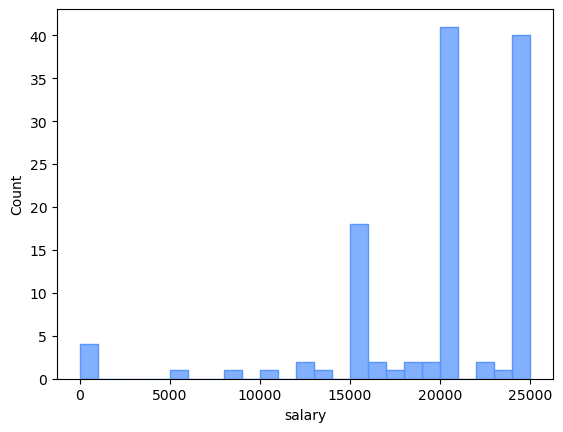

In [17]:
sns.histplot(df[df['salary'] <= 25000]['salary'], bins=25, color='#5996fc', edgecolor='#5996fc')

В данном случае, мы удалим значения зарплат которые лежат выше 100000 и ниже 15000.

In [18]:
print('К удалению:', df[df['salary'] >= 100000]['salary'].count())
df = df[(df['salary'] < 100000) & (df['salary'] >= 15000)]

К удалению: 27


Также мы можем наблюдать слишком маленькие значения зарплат. Удалим значения что стоят за левой зеленой линией - то есть все до 0.05 квантиля.

In [19]:
print('К удалению:', df[df['salary'] <= df['salary'].quantile(0.05)]['salary'].count())
df = df[df['salary'] > df['salary'].quantile(0.05)]

К удалению: 20


#### 2. Столбец experience

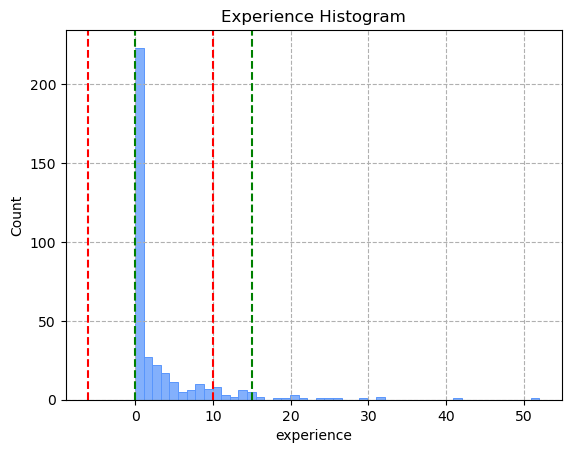

In [20]:
get_histplot(df, 'experience')

In [21]:
df.describe()['experience']

count    368.000000
mean       3.309783
std        6.292309
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       52.000000
Name: experience, dtype: float64

Мы не знаем в каких единицах представлен опыт работы - месяцы или годы. Выведем описание опыта самых опытных людей, и попробуем выяснить:

In [22]:
display(*df[df['experience'] >= 40]['workExperienceList'])

'[{"achievements": "<p>Разработка и отладка УП для стоек ЧПУ: ФАНУК, МАЗАТРОЛ, лазерный комплекс ТРУМПФ.</p>\\n<p>15 лет вел курсы повышения квалификации наладчиков станков с ЧПУ в учебном центре \\"ГАЗ\\"</p>", "company_name": "ПАО \\"ГАЗ\\"", "date_from": "1970-11-01T00:00:00+0300", "date_to": "2022-06-01T00:00:00+0300", "demands": "<p>Разработка и отладка УП для фрезерных ОЦ</p>", "owner_id": "12fcdf30-fb6a-11ec-92cb-1b29d3b53cbb", "position": "ведущий инженер-технолог, наладчик станков с ЧПУ 6 разряда", "relevant": false, "type": "WorkExperience"}]'

'[{"company_name": "ВС СССР", "date_from": "1981-06-01T00:00:00+0400", "date_to": "1990-09-01T00:00:00+0400", "demands": "<p>разработка программного обеспечения</p>\\n<p>анализ информации</p>", "owner_id": "00e38ea0-8e81-11ea-9188-1fdc17069750", "position": "инженер-испытатель", "relevant": false, "type": "WorkExperience"}, {"company_name": "Минюст РБ, РФ", "date_from": "1994-09-01T00:00:00+0400", "date_to": "2002-08-01T00:00:00+0400", "demands": "<p>информатизация, руководство Бурятским Центром правовой информатизации Минюста РФ</p>", "owner_id": "00e38ea0-8e81-11ea-9188-1fdc17069750", "position": "правовая информатизация, руководитель", "relevant": false, "type": "WorkExperience"}, {"achievements": "<p>О себе: ..., по-проектно, удаленно, высшее, профи....самозанятый</p>\\n<p>Предпочтительно Битрикс, битрикс</p>\\n<p>тестировать, переделать, исправить, сопровождать, сделать сайты Bitrix,&nbsp;Python, Django&nbsp;</p>\\n<p>Разработка, проектирование,&nbsp; документация, тестирование,&n

Столбец experience рассчитывается автоматически исходя из сумм разности года ухода из места работы и началом работы. Единицы представлены в годах.

На основе графика можно сделать вывод о том, что более половины соискателей имеют опыт работы меньше одного года.


Удалим все записи, что за зеленой линией.

In [23]:
print('К удалению:', df[df['experience'] >= df['experience'].quantile(0.95)]['experience'].count())
df = df[df['experience'] < df['experience'].quantile(.95)]

К удалению: 21


#### 3. Столбец fullness_rate

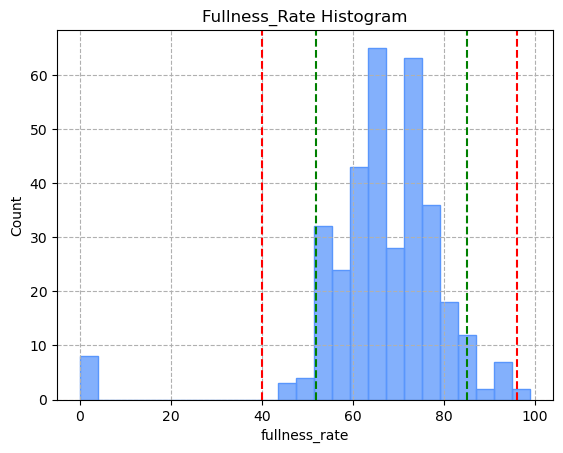

In [24]:
get_histplot(df, 'fullness_rate')

In [25]:
df.describe()['fullness_rate']

count    347.000000
mean      66.867435
std       14.292152
min        0.000000
25%       61.000000
50%       67.000000
75%       75.000000
max       99.000000
Name: fullness_rate, dtype: float64

Большая часть пользователей заполняет анкету от 50 до 85 процентов.

Удалим записи со значениями меньше 40. Вероятно, эти люди не стали ничего заполнять в своем резюме.

In [26]:
print('К удалению:', df[df['fullness_rate'] <= 40]['fullness_rate'].count())
df = df[df['fullness_rate'] > 40]

К удалению: 8


#### Итог

Мы очистили данные от редких значений - по итогу удалено 83 строки. Необходимо сбросить индексы строк таблицы

In [27]:
df = df.reset_index(drop=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   education                292 non-null    object
 1   drive_license            52 non-null     object
 2   experience               339 non-null    int64 
 3   salary                   339 non-null    int64 
 4   professional_skills      19 non-null     object
 5   add_skills               14 non-null     object
 6   busy_type                339 non-null    object
 7   business_trip            339 non-null    object
 8   other_certificates       30 non-null     object
 9   retraining_capability    339 non-null    object
 10  fullness_rate            339 non-null    int64 
 11  professionList           339 non-null    object
 12  workExperienceList       196 non-null    object
 13  educationList            339 non-null    object
 14  additionalEducationList  29 non-null     o

### Пропуски в данных

Посмотрим сколько осталось пропусков в столбцах.

In [29]:
df.isna().sum()

education                   47
drive_license              287
experience                   0
salary                       0
professional_skills        320
add_skills                 325
busy_type                    0
business_trip                0
other_certificates         309
retraining_capability        0
fullness_rate                0
professionList               0
workExperienceList         143
educationList                0
additionalEducationList    310
languageKnowledge           98
hardSkills                 200
softSkills                 221
localityName                 0
dtype: int64

#### Удаление строк и столбцов

Во многих столбцах 90% значений составляют пропуски. Рассмотрим столбцы **professional_skills, add_skills, other_certificates, additionalEducationList**. В них настолько много пропусков, что наличие того или иного навыка или сертификата может и не сыграть роли для прогнозирования. 

Нужно убедиться в том, что наличие или отсутствие пропуска в этих столбцах не влияет на желаемую зарплату. Мы выведем медианную зарплату записей с пропусками и записей без пропусков, если разница будет незначительной, то столбец не будет нести ценность.

In [30]:
useless_columns = ['professional_skills', 'add_skills', 'other_certificates', 'additionalEducationList']

for column in useless_columns:
    df_copy = df[[column, 'salary']].copy()
    df_copy[column] = df_copy[column].fillna(0)
    df_copy[column] = df_copy[column].where(df_copy[column] == 0, 1)
    
    print(column.upper())
    print('Медианная зарплата с навыком', df_copy[df_copy[column] == 1]['salary'].median()) 
    print('Медианная зарплата без навыка', df_copy[df_copy[column] == 0]['salary'].median())
    print()

PROFESSIONAL_SKILLS
Медианная зарплата с навыком 30000.0
Медианная зарплата без навыка 35000.0

ADD_SKILLS
Медианная зарплата с навыком 31000.0
Медианная зарплата без навыка 35000.0

OTHER_CERTIFICATES
Медианная зарплата с навыком 30000.0
Медианная зарплата без навыка 39157.0

ADDITIONALEDUCATIONLIST
Медианная зарплата с навыком 45000.0
Медианная зарплата без навыка 35000.0



В первых трех столбцах зарплата с наличием навыка ниже, чем с зарплата с пропуском, что сомнительно, одно лишь начилие навыка не означает бОльшую зарплату, а значит нет смысла оставлять эти столбцы.

Однако есть вероятность, что столбец о дополнительном образовании влияет на увеличение желаемой зарплаты, в этом есть логика.

In [31]:
useless_columns.pop()
df.drop(useless_columns, axis=1, inplace=True)

#### Заполнение одним значением

Столбец **education** содержит около 15% пропусков. Это значительное количество, поэтому обратим внимание на **столбец educationList**, он содержит данные об образовательном учреждении, где человек обучался. 

У нас есть пропуски в столбце education и отсутствие пропусков в столбце educationList, возможно во втором столбце будет присутствовать информация об уровне образования. Выведем строки которые имеют пропуск в столбце education.

Так как в этом столбце содержится большое количество всяких пунктуационных символов и английских слов, не несущих информацию, мы очистим этот столбец функцией `clean_text()` и оставим лишь русские слова. Таким образом мы легко определим присутствие уровня образования.

In [32]:
df['educationList'] = [clean_text(text, 'russian') for text in df['educationList']]
print(*df[df['education'].isna()==True]['educationList'])

               Туризм    Разработка гостевой книги для интернет сайта Математический Магистр информатики преподаватель Информатика      МОУ СОШ г Усть Кута      Информационные системы по отраслям ГБПОУ Тулунский Аграрный Техникум   Прикладная информатика по областям  Биология        Киномеханик Киномеханик  


В этой информации можно найти лишь одно слово в контексте уровня образования - техникум. То есть мы бы могли восстановить 1 пропуск, однако усилия не стоят свеч.

Можно удалить столбец educationList, так как в нем больше не будет полезной информации. В теории, если бы было больше данных, нам бы пригодились названия университетов в которых учился человек, но в рамках этого тестового задания в этом будет мало смысла.

In [33]:
df.drop('educationList', axis=1, inplace=True)

Пропуски в столбцах **education, drive_license, wordExperienceList, softSkills, hardSkills** являются неслучайными. Водительские права и опыт работы или какие то навыки, вероятно, просто отсутствуют у человека, поэтому пропускам можно **присвоить значение *'Нет'*.**


Пропуски в столбце **languageKnowledge** могут быть связаны с отсутствием знания второго языка, но основной язык люди не посчитали нужным заполнить. **Заполним их, добавив *'русский'*** в место пропуска.

Остался столбец **additionalEducationList**. Так как данных в этом столбце очень мало, то нам скорее важен факт самого присутствия дополнительного образования, чем что-то более конкретное. Поэтому всем **пропускам мы присвоим значение '0'**, а остальные значения заменим на '1'.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   education                292 non-null    object
 1   drive_license            52 non-null     object
 2   experience               339 non-null    int64 
 3   salary                   339 non-null    int64 
 4   busy_type                339 non-null    object
 5   business_trip            339 non-null    object
 6   retraining_capability    339 non-null    object
 7   fullness_rate            339 non-null    int64 
 8   professionList           339 non-null    object
 9   workExperienceList       196 non-null    object
 10  additionalEducationList  29 non-null     object
 11  languageKnowledge        241 non-null    object
 12  hardSkills               139 non-null    object
 13  softSkills               118 non-null    object
 14  localityName             339 non-null    o

## Предобработка данных

На этом этапе мы сделаем следующее:
1. Обработка пропусков.
2. Создание новых признаков
    * Представить drive_license, languageKnowledge в более информативном виде, закодировать.
    * Представить workExperienceList, professionList  в более информативный вид, поссчитать количество компаний для каждого человека.
    * Представить hardSkills, softSkills  в более информативный вид, поссчитать количество навыков для каждого человека.
    * Разделить значения state_region_code на группы, закодировать
3. Подготовка признаков
    * Кодировка остальных признаков
    * Разбиение на выборки
    * Стандартизация

### Обработка пропусков

Мы определили, какие столбцы мы оставляем для дальнейшей работы, и решили что делать с пропусками. Напишем функцию которая обрабатывает пропуски и оставляет необходимые столбцы для изначального датасета.

In [35]:
def table_processing(df):
    table = df.copy()
    usefull_columns = ['localityName', 'education', 'drive_license', 'experience', 'salary', 
                       'busy_type', 'business_trip', 'retraining_capability', 'fullness_rate',
                       'professionList', 'workExperienceList', 'additionalEducationList', 'languageKnowledge', 
                       'hardSkills', 'softSkills']
    table = table[usefull_columns]
    table.replace('[]', None, inplace=True)
    columns = ['education', 'drive_license', 'workExperienceList', 'softSkills', 'hardSkills']
    table[columns] = table[columns].fillna('нет')
    
    table['languageKnowledge'].fillna('русский', inplace=True)
    
    table['additionalEducationList'].fillna(0, inplace=True)
    table['additionalEducationList'] = [1 if text != 0 else 0 for text in table['additionalEducationList']]
    
    return table

Проверим ее на изначальном датасете:

In [36]:
table_processing(data).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   localityName             425 non-null    object
 1   education                425 non-null    object
 2   drive_license            425 non-null    object
 3   experience               425 non-null    int64 
 4   salary                   425 non-null    int64 
 5   busy_type                425 non-null    object
 6   business_trip            425 non-null    object
 7   retraining_capability    425 non-null    object
 8   fullness_rate            425 non-null    int64 
 9   professionList           425 non-null    object
 10  workExperienceList       425 non-null    object
 11  additionalEducationList  425 non-null    int64 
 12  languageKnowledge        425 non-null    object
 13  hardSkills               425 non-null    object
 14  softSkills               425 non-null    o

Отлично, функцию можно будет применять к новым данным. А теперь применим ее к нашему df:

In [37]:
df = table_processing(df)
df.head()

,localityName,education,drive_license,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,workExperienceList,additionalEducationList,languageKnowledge,hardSkills,softSkills
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,нет,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...","[{""company_name"": ""Индивидуальный предпринимат...",0,"[{""code_language"": ""Английский"", ""level"": ""Чте...",нет,нет
1,г.-Санкт-Петербург,Среднее,нет,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""Corbina Telecom"", ""date_fro...",0,"[{""code_language"": ""Русский"", ""level"": ""Родной...",нет,нет
2,"Оренбургская-область,-г.-Медногорск",Среднее,нет,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""КФКСТ и МП г. Медногорска"",...",0,"[{""code_language"": ""Французский"", ""level"": ""Ба...","[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d..."
3,"Республика-Татарстан,-г.-Казань",нет,нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",нет,0,русский,нет,нет
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,нет,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",нет,0,"[{""code_language"": ""Русский"", ""level"": ""Родной...","[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9..."


### Создание и анализ новых признаков

Функция ниже будет кодировать столбец схоже по принципу one hot encoding. Еще ниже будет наглядное объяснение этой функции на примере столбца drive_license и languageKnowledge.

In [38]:
def encoding(dataframe, relevant_column, check_dict):
    dataframe = dataframe.copy()
    for new_column, check in check_dict.items():
        temp_column = []
        for text in dataframe[relevant_column]:
            if any(example in text for example in check):
                temp_column.append(1)
            else:
                temp_column.append(0)
        dataframe[new_column] = temp_column
    return dataframe

#### 1. Столбец drive_license

In [39]:
df['drive_license'].value_counts()

нет           287
['B']          40
['B',-'C']     12
Name: drive_license, dtype: int64

Столбец **drive_license** имеет комбинации из следующих вариантов:
* B
* C
* нет

Так как в данном столбце присутствуют комбинации из различных вариантов, вместо того, чтобы каждой комбинации давать отдельный класс, мы создадим булевые столбцы под каждую водительскую лицензию (в нашем случае под B и C, так как другие в данных отсутствуют). 

Функция `encoding()` будет создавать столбец, название которого - ключ переменной `check_list`, если в рассматриваевом столбце (relevant_column) мы найдем хоть одну запись из списка значения ключа.

In [40]:
check_dict = {'B_license': ['B'],
              'C_license': ['C']}

df = encoding(df, 'drive_license', check_dict)
df.head()

,localityName,education,drive_license,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,workExperienceList,additionalEducationList,languageKnowledge,hardSkills,softSkills,B_license,C_license
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,нет,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...","[{""company_name"": ""Индивидуальный предпринимат...",0,"[{""code_language"": ""Английский"", ""level"": ""Чте...",нет,нет,0,0
1,г.-Санкт-Петербург,Среднее,нет,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""Corbina Telecom"", ""date_fro...",0,"[{""code_language"": ""Русский"", ""level"": ""Родной...",нет,нет,0,0
2,"Оренбургская-область,-г.-Медногорск",Среднее,нет,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""КФКСТ и МП г. Медногорска"",...",0,"[{""code_language"": ""Французский"", ""level"": ""Ба...","[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...",0,0
3,"Республика-Татарстан,-г.-Казань",нет,нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",нет,0,русский,нет,нет,0,0
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,нет,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",нет,0,"[{""code_language"": ""Русский"", ""level"": ""Родной...","[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...",0,0


Функция `encoding` работает верно. Столбец drive_license больше не нужен.

In [41]:
df.drop(['drive_license'], axis=1, inplace=True)

Так как лицензию C имеет очень малое количество людей, нам нужно убедиться в его ценности для машинного обучения. Посмотрим, значительно ли отличаются зарплаты людей в зависимости от наличие тех или иных водительских лицензий.

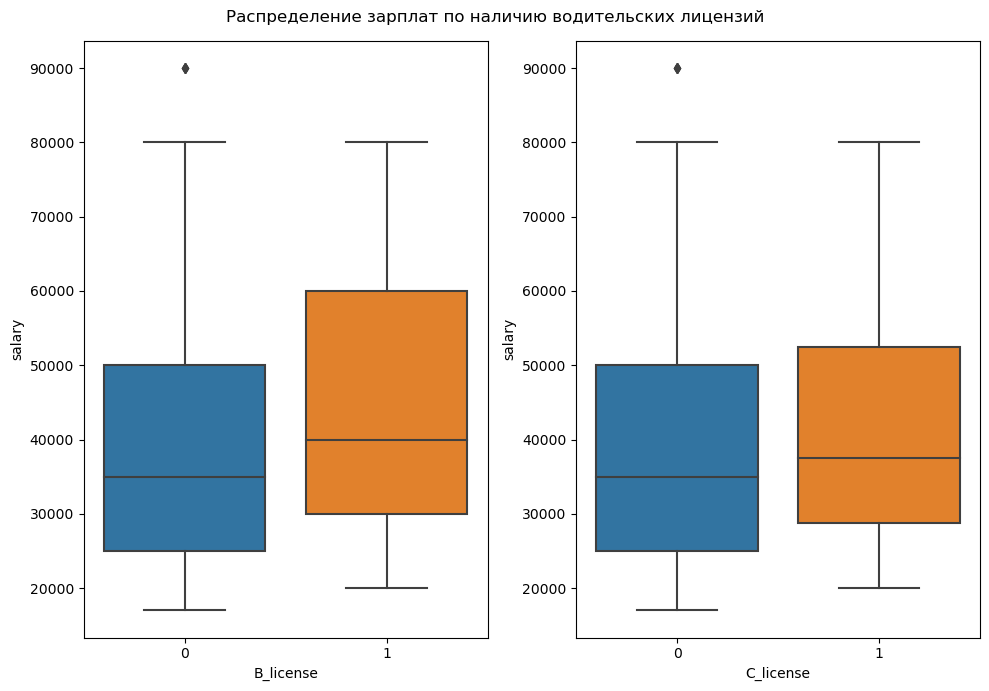

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,7))
plt.suptitle('Распределение зарплат по наличию водительских лицензий')
sns.boxplot(data=df, y='salary', x='B_license', ax=ax1)
sns.boxplot(data=df, y='salary', x='C_license', ax=ax2)
plt.tight_layout()
plt.show()

Вывод:
1. На основе распределений можно сказать, в некоторых случаях наличие водительской лицензии может увеличить размер зарплаты, однако медианы будут равны. 
2. Распределение B не отличается от C, поэтому столбец C нам не нужен.

In [43]:
df.drop(['C_license'], axis=1, inplace=True)

#### 2. Столбец languageKnowledge

Эту же функцию можно использовать и для столбца **languageKnowledge**. Однако тут состоит сложность в том, чтобы передать не только присутствие языка, но и уровень владения этим языком.

Сперва определим слова, которые используются для определения уровня владения, заодно узнаем какие языки используются чаще всего. Для этого у нас есть функция `find_top_words()`

In [44]:
# find_top_words(df['languageKnowledge'], language='russian', limit=30)

В столбце используется множество языков с разных регионов евразии. Можно разделить их на группы: *европейские, азиатские, южные и снг*.

Также используются следующие уровни владения языком: *базовый, родной, чтение, словарь, письмо, свободный, способный*. По большому счету их можно определить в 2 класса - 0 и 1 (базовое владение, уверенное владение).

Теперь лемматизируем столбец, чтобы в дальнейшем мы могли осуществлять поиск по ключевым словам.

In [45]:
df['languageKnowledge'] = [clean_text(text, 'russian') for text in df['languageKnowledge']]
df['languageKnowledge'] = [lemmatize_text(text) for text in tqdm(df['languageKnowledge'])]

100%|██████████| 339/339 [04:39<00:00,  1.21it/s]


Английский встречается на порядок чаще чем другие европейские языки, поэтому в переменной `check_list` английский и европейские языки мы определим в отдельные столбцы.

In [46]:
check_dict = {'eng': ['английский'],
              'eu': ['болгарский','венгерский','греческий','датский','ирландский',
                     'испанский','итальянский','латышский','литовский','мальтийский','немецкий','нидерландский',
                     'польский','португальский','румынский','словацкий','словенский','финский','французский',
                     'чешский','шведский','эстонский'],
# людей владеющих азиатскими и ближневосточными языками буквально 3 в таблице. Оставим европейские и снг языки.
#              'ap': ['китайский', 'индонезийский', 'бангла', 'японский', 'панджаби', 'филиппинский', 'корейский',
#                    'вьетнамский', 'телугу', 'тамильский'],
#              'me': ['арабский', 'иврит', 'турецкий', 'персидский'], 
              'ru': ['русский','татарский', 'башкирский', 'чувашский', 'бурятский', 'мордовский', 'карельский', 'удмуртский', 
                    'марийский', 'черкесский', 'ногайский', 'калмыцкий', 'якутский', 'венгерский', 'русинский', 'гагаузский', 
                    'казахский', 'кыргызский', 'таджикский', 'узбекский', 'туркменский', 'азербайджанский', 'армянский', 
                    'украинский', 'белорусский', 'молдавский', 'грузинский', 'литовский', 'абхазский', 
                    'осетинский', 'аварский', 'даргинский', 'чеченский']}

df = encoding(df, 'languageKnowledge', check_dict)
df.head()

,localityName,education,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,workExperienceList,additionalEducationList,languageKnowledge,hardSkills,softSkills,B_license,eng,eu,ru
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...","[{""company_name"": ""Индивидуальный предпринимат...",0,английский чтение и письмо со словарь русский ...,нет,нет,0,1,0,1
1,г.-Санкт-Петербург,Среднее,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""Corbina Telecom"", ""date_fro...",0,русский родной\n,нет,нет,0,0,0,1
2,"Оренбургская-область,-г.-Медногорск",Среднее,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""КФКСТ и МП г. Медногорска"",...",0,французский базовый английский базовый\n,"[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...",0,1,1,0
3,"Республика-Татарстан,-г.-Казань",нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",нет,0,русский\n,нет,нет,0,0,0,1
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",нет,0,русский родной\n,"[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...",0,0,0,1


In [47]:
# df['languageKnowledge'].unique()

Исходя из результата кода выше, можно увидеть закономерность в которой описывается уровень владения языком. Они записаны по следующим шаблонам:
* (язык) чтение и письмо со словарь
* (язык) базовый
* (язык) родной
* (язык) способный проходить собеседование
* (язык) свободный

Если в записи столбца languageKnowledge мы находим продвинутый уровень пользования языком, то в определенном столбце (eu, eng или ru), класс владения языком повышается до 2, иначе он остается на 1 или 0.

In [48]:
high_levels = ['родной', 'способный', 'свободный']
for column_name, check in check_dict.items():
    row_number=0
    for text in df['languageKnowledge']:
        if any(f'{lang} {level}' in text
               for lang in check 
               for level in high_levels):
            df.loc[row_number, column_name] = 2
        row_number+=1
        
df.head()

,localityName,education,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,workExperienceList,additionalEducationList,languageKnowledge,hardSkills,softSkills,B_license,eng,eu,ru
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...","[{""company_name"": ""Индивидуальный предпринимат...",0,английский чтение и письмо со словарь русский ...,нет,нет,0,1,0,1
1,г.-Санкт-Петербург,Среднее,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""Corbina Telecom"", ""date_fro...",0,русский родной\n,нет,нет,0,0,0,2
2,"Оренбургская-область,-г.-Медногорск",Среднее,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""КФКСТ и МП г. Медногорска"",...",0,французский базовый английский базовый\n,"[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...",0,1,1,0
3,"Республика-Татарстан,-г.-Казань",нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",нет,0,русский\n,нет,нет,0,0,0,1
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",нет,0,русский родной\n,"[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...",0,0,0,2


Проверим правильность выполнения функции, выведем тех кто хорошо владеет русским языком, и при этом владеет любым европейским на базовом уровне.

In [49]:
print(*df[(df['ru']==2) & (df['eu']==1)]['languageKnowledge'])

немецкий чтение и письмо со словарь английский способный проходить собеседование русский родной
 английский способный проходить собеседование украинский родной русский родной польский базовый
 немецкий базовый русский родной английский базовый
 английский чтение и письмо со словарь немецкий чтение и письмо со словарь русский родной
 немецкий чтение и письмо со словарь английский свободный русский родной
 русский родной английский базовый испанский базовый



Функция сработала верно.

Выведем графики показывающие количество людей владеющих тем или иным языком, и на каком уровне. 

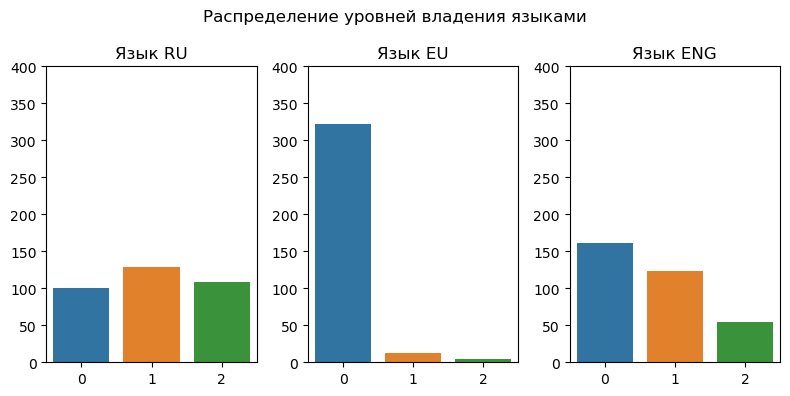

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8,4))
plt.suptitle('Распределение уровней владения языками')
plt.ylim([0,270])
for lang, ax in dict({'ru':ax1, 'eu':ax2, 'eng':ax3}).items():    
    ax.set_title(f'Язык {lang.upper()}')
    sns.barplot(
        x=df[lang].value_counts().index,
        y=list(df[lang].value_counts()),
        ax=ax)
    ax.set_ylim([0,400])
plt.tight_layout()
plt.show()

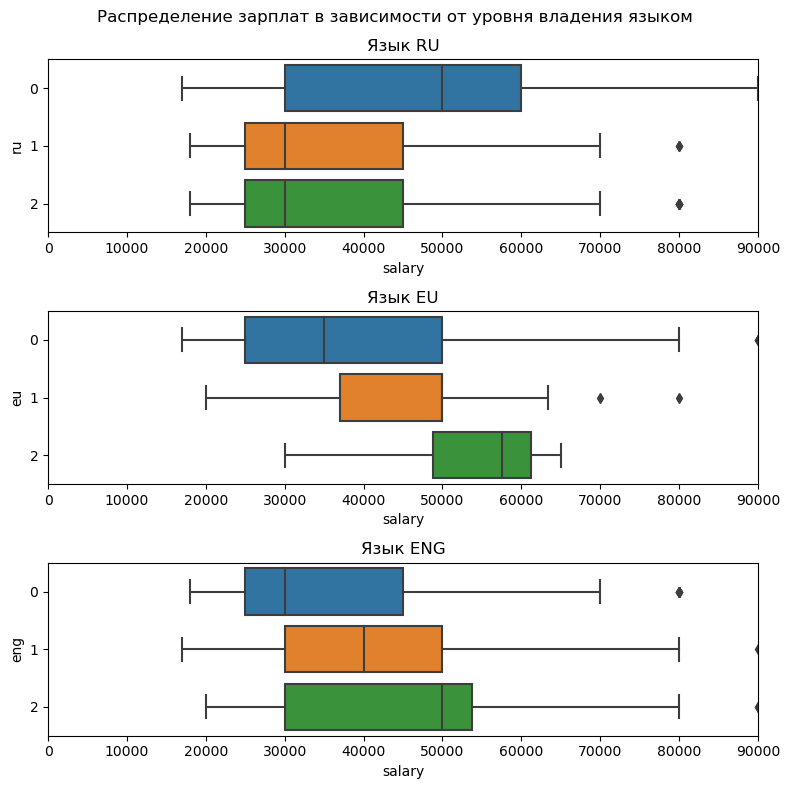

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8,8))
plt.suptitle('Распределение зарплат в зависимости от уровня владения языком')
plt.ylim([0,270])
for lang, ax in dict({'ru':ax1, 'eu':ax2, 'eng':ax3}).items():    
    ax.set_title(f'Язык {lang.upper()}')
    sns.boxplot(
        data=df,
        y=lang,
        x='salary',
        orient='h',
        ax=ax)
    ax.set_xlim([0,90000])
plt.tight_layout()
plt.show()

1. С увеличением уровня знания английского и другого европейского языка - зарплата заметно растет. Каждый уровень прибавляет в среднем 10000 рублей к зарплате.

2. Люди, которые не указали русский язык в резюме, имеют зарплату больше чем те кто указал. Вероятно, если человек знает второй язык не станет указывать русский язык.

Европейскими языками владеет слишком малое количество человек, мы решили удалять столбцы, в которых одно значение встречается в 95% случаев.

In [52]:
df.drop(['eu'], axis=1, inplace=True)

In [53]:
df.drop(['languageKnowledge'], axis=1, inplace=True)

#### 3. Столбец workExperienceList

In [54]:
# df['workExperienceList'].unique()[:3]

В данном столбце можно опираться на то, что каждый опыт работы в компании начинается с *'company_name'*. Таким образом мы можем посчитать количество компаний, в которых работал человек и образовать на этом новый признак.

In [55]:
df['companies_exp'] = list(map(lambda text: text.count('company_name'), df['workExperienceList']))
df.head()

,localityName,education,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,workExperienceList,additionalEducationList,hardSkills,softSkills,B_license,eng,ru,companies_exp
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...","[{""company_name"": ""Индивидуальный предпринимат...",0,нет,нет,0,1,1,2
1,г.-Санкт-Петербург,Среднее,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""Corbina Telecom"", ""date_fro...",0,нет,нет,0,0,2,3
2,"Оренбургская-область,-г.-Медногорск",Среднее,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...","[{""company_name"": ""КФКСТ и МП г. Медногорска"",...",0,"[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...",0,1,0,1
3,"Республика-Татарстан,-г.-Казань",нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",нет,0,нет,нет,0,0,1,0
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",нет,0,"[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...",0,0,2,0


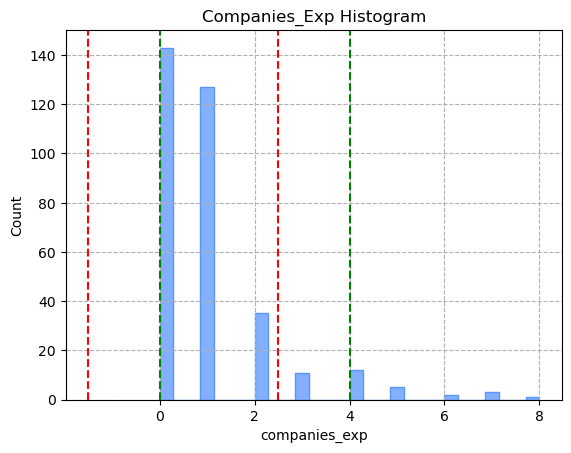

In [56]:
get_histplot(df, 'companies_exp')

Text(0.5, 1.0, 'Зависимость зарплаты от количества компаний в резюме')

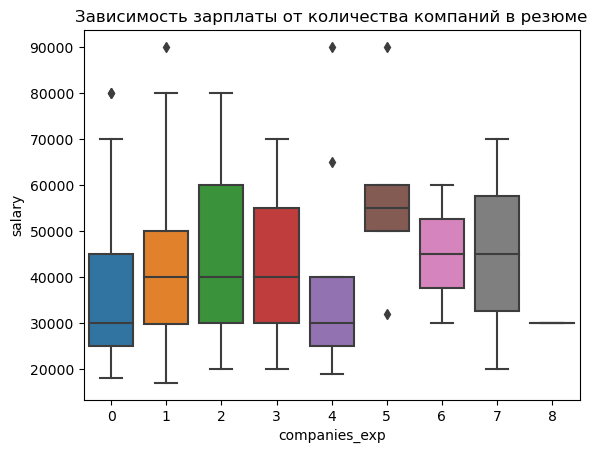

In [57]:
sns.boxplot(data=df, x='companies_exp', y='salary')
plt.title('Зависимость зарплаты от количества компаний в резюме')

1. Всего 5% людей работали более чем в 4 компаниях. Зарплаты этих людей неоднозначны, но вцелом выше чем у других.
2. Зарплаты людей без опыта ниже всех остальных.

5% людей имеют слишком большие зарплаты по сравнению с остальными, эти записи - исключения из правил, или же - выбросы, от которых стоит избавиться.

In [58]:
print('К удалению: ', len(df[df['companies_exp'] > 3]))
df = df[df['companies_exp'] <= 3]

К удалению:  23


Столбец wordExperienceList можно удалить:

In [59]:
df.drop(['workExperienceList'], axis=1, inplace=True)

#### 4. Столбцы hardSkills и softSkills

In [60]:
# df['hardSkills'].unique()[:10]

In [61]:
# df['softSkills'].unique()[:10]

Подобно подсчету количества компаний в прошлом пункте, мы подсчитаем количество навыков, которые использует человек. Каждый навык помечается словом *'hard_skill_name'* и *'soft_skill_name'* соответственно. Дело лишь в том, что в первом столбце часто содержится информация, которая должна находиться в софт скиллах (как например: чувство юмора, работа в команде).

Поэтому, создадим всего один столбец, который будет содержать сумму количества хард и софт скиллов.

In [62]:
hard = list(map(lambda text: text.count('hard_skill_name'), df['hardSkills']))
soft = list(map(lambda text: text.count('soft_skill_name'), df['softSkills']))
df['skills_quantity'] = np.array(hard) + np.array(soft)
df.head()

,localityName,education,experience,salary,busy_type,business_trip,retraining_capability,fullness_rate,professionList,additionalEducationList,hardSkills,softSkills,B_license,eng,ru,companies_exp,skills_quantity
0,"Ростовская-область,-г.-Ростов-на-Дону",Среднее-профессиональное,2,30000,Полная-занятость,Готов-к-командировкам,Готов-к-переобучению,79,"[{""code_profession"": ""270999"", ""code_professio...",0,нет,нет,0,1,1,2,0
1,г.-Санкт-Петербург,Среднее,14,30000,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,69,"[{""code_profession"": ""258573"", ""code_professio...",0,нет,нет,0,0,2,3,0
2,"Оренбургская-область,-г.-Медногорск",Среднее,0,25000,Удаленная,Не-готов-к-командировкам,Готов-к-переобучению,73,"[{""code_profession"": ""258573"", ""code_professio...",0,"[{""hard_skill_name"": ""стрессоустойчивость"", ""o...","[{""owner_id"": ""02efefb0-0e43-11ed-81ab-7fb917d...",0,1,0,1,5
3,"Республика-Татарстан,-г.-Казань",нет,0,39157,Полная-занятость,Не-готов-к-командировкам,Готов-к-переобучению,53,"[{""code_profession"": ""258573"", ""code_professio...",0,нет,нет,0,0,1,0,0
4,"Орловская-область,-г.-Новосиль",Среднее-профессиональное,0,30000,Частичная-занятость,Не-готов-к-командировкам,Не-готов-к-переобучению,71,"[{""code_profession"": ""149959"", ""code_professio...",0,"[{""hard_skill_name"": ""умение работать в команд...","[{""owner_id"": ""029ebe60-e0d0-11ec-a466-839f0d9...",0,0,2,0,5


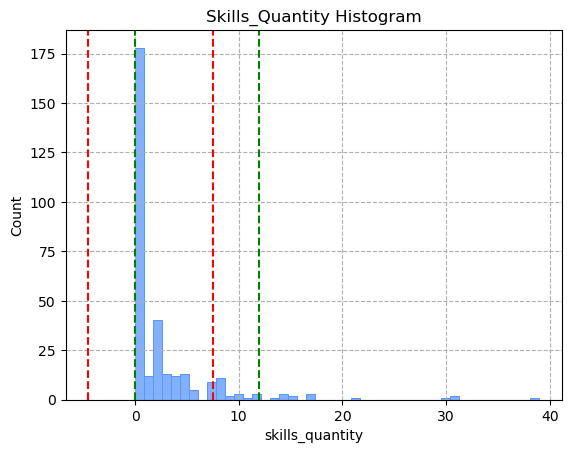

In [63]:
get_histplot(df, 'skills_quantity')

Необходимо избавиться от выбросов, удалим строки с количеством навыков более чем на 95% квантиле.

Посмотрим на корреляцию между количеством навыков и зарплатой по коэффициентам и Спирмена и Пирсона:

In [64]:
print('Корреляция Спирмена', df['skills_quantity'].corr(df['salary'], method='spearman'))
print('Корреляция Пирсона', df['skills_quantity'].corr(df['salary'], method='pearson'))

Корреляция Спирмена 0.14354302887548037
Корреляция Пирсона 0.019639599048099185


Наблюдается слабая нелинейная взаимосвязь между количеством навыков и зарплатой. Удалим редкие значения - количества навыков 12 и более:

In [65]:
print('К удалению: ', len(df[df['skills_quantity'] >= 12]))
df = df[df['skills_quantity'] < 12]

К удалению:  17


In [66]:
print('Корреляция Спирмена', df['skills_quantity'].corr(df['salary'], method='spearman'))
print('Корреляция Пирсона', df['skills_quantity'].corr(df['salary'], method='pearson'))

Корреляция Спирмена 0.15816545627498105
Корреляция Пирсона 0.11001248889818342


Взаимосвязь увеличилась.

In [67]:
df.drop(['hardSkills', 'softSkills'], axis=1, inplace=True)

#### 5. Столбец professionList

In [68]:
# print(*df['professionList'][:3])

В этом столбце мы можем вывести в отдельный столбец сферу деятельности. Следующий код может это сделать:

In [69]:
new_column = []
for text in df['professionList']:
    attributes = text.split(',')
    for attribute in attributes:
        if 'code_professional_sphere' in attribute:
            sphere = attribute.split(':')[1][2:-1]
            new_column.append(sphere)
            
df['professionSphere'] = new_column
df['professionSphere'].value_counts()

InformationTechnology        211
DeskWork                      21
Finances                      10
NotQualification               8
Industry                       8
Education                      6
Marketing                      5
StateServices                  5
WorkingSpecialties             5
AccountingTaxesManagement      4
Sales                          3
ServiceMaintenance             2
Medicine                       2
SportsFitnessBeautySalons      2
Safety                         1
Culture                        1
ElectricpowerIndustry          1
MechanicalEngineering          1
RootLightIndustry              1
Resources                      1
Transport                      1
Name: professionSphere, dtype: int64

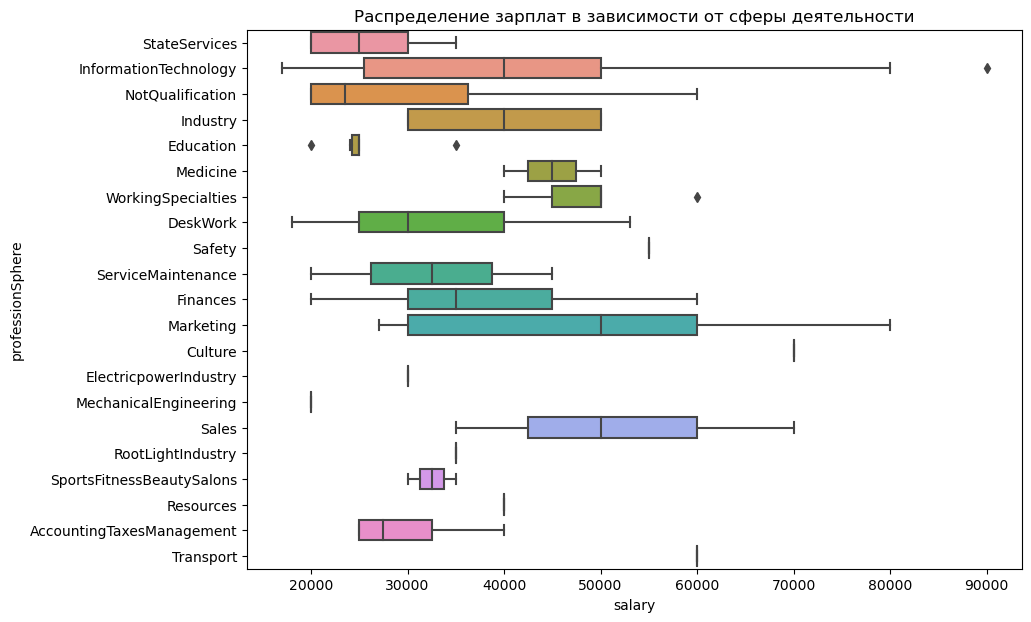

In [70]:
plt.figure(figsize=(10,7))
plt.title('Распределение зарплат в зависимости от сферы деятельности')
sns.boxplot(data=df, x='salary', y='professionSphere', orient='h')
plt.show()

Сфер оказалось слишком много, большую часть из них можно определить под общую категорию 'Другая'. По итогу у нас будут следующие сферы:
* InformationTechnology
* DeskWork
* Finances
* Industry
* NotQualififcation
* Другая

In [71]:
df['professionSphere'] = ['Другая'  if sphere not in ['InformationTechnology', 'DeskWork', 
                                                      'Finances', 'Industry', 'NotQualification']
                          else sphere for sphere in df['professionSphere']]
df['professionSphere'].value_counts()

InformationTechnology    211
Другая                    41
DeskWork                  21
Finances                  10
NotQualification           8
Industry                   8
Name: professionSphere, dtype: int64

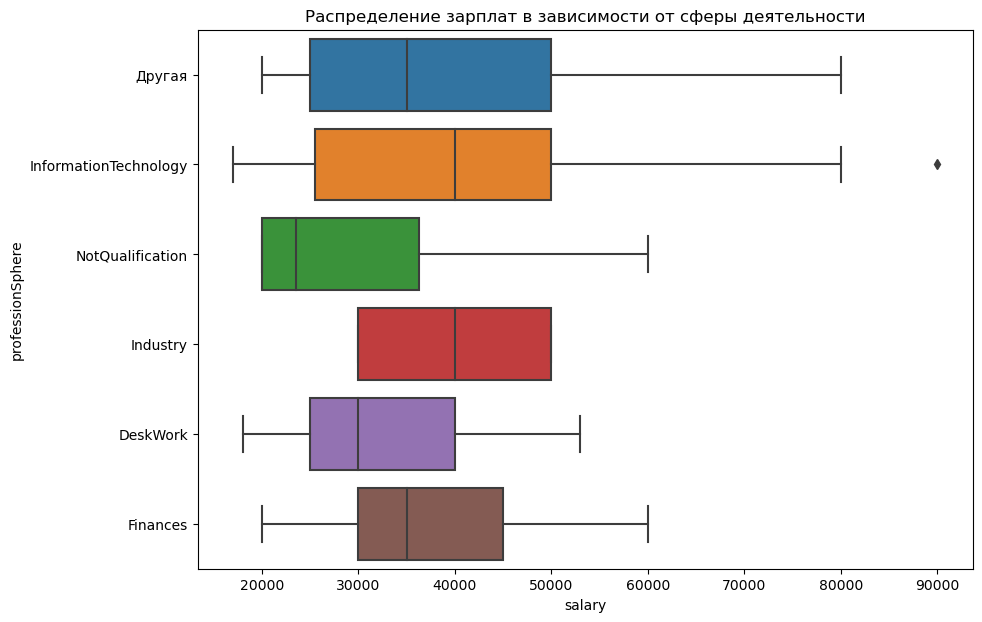

In [72]:
plt.figure(figsize=(10,7))
plt.title('Распределение зарплат в зависимости от сферы деятельности')
sns.boxplot(data=df, x='salary', y='professionSphere', orient='h')
plt.show()

Самая низкая зарплата, как ни странно, у неквалифицированных, в то время как самая большая у людей с релевантной классификацией - информационные технологии.

In [73]:
df.drop(['professionList'], axis=1, inplace=True)

#### 6. Столбец localityName

Разделим регионы на следующие группы:
1. Москва
2. Санкт-Петербург
3. Город-миллионник
4. Обычный город

In [74]:
million_cities = ['Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань',
                         'Челябинск', 'Омск', 'Самара', 'Ростов-на-Дону', 'Уфа',
                         'Красноярск', 'Пермь', 'Воронеж', 'Волгоград']

In [75]:
new_column = []
for city in df['localityName']:
    if 'Москва' in city:
        new_column.append('Москва')
    elif 'Санкт-Петербург' in city:
        new_column.append('Санкт-Петербург')
    elif any(million_city in city for million_city in million_cities):
        new_column.append('Город-миллионник')
    else:
        new_column.append('Обычный город')

df['localityName'] = new_column

In [76]:
df['localityName'].value_counts()

Обычный город       223
Город-миллионник     56
Санкт-Петербург      14
Москва                6
Name: localityName, dtype: int64

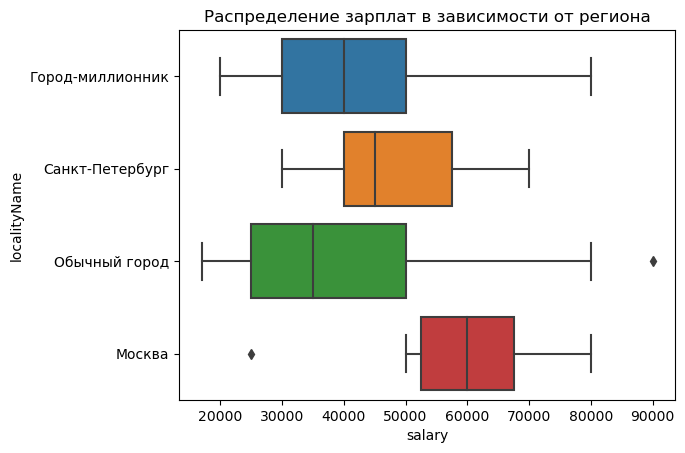

In [77]:
plt.title('Распределение зарплат в зависимости от региона')
sns.boxplot(data=df, y='localityName', x='salary', orient='h')
plt.show()

Ожидаемо, чем крупнее город, тем выше зарплата. Москва встречается крайне редко, с другой стороны наличие ее в записи будет сильной меткой о повышении зарплаты.

### Изучение остальных распределений

#### 1. Столбец busy_type

In [78]:
df['busy_type'].value_counts()

Полная-занятость       238
Удаленная               35
Частичная-занятость     13
Стажировка              12
Временная                1
Name: busy_type, dtype: int64

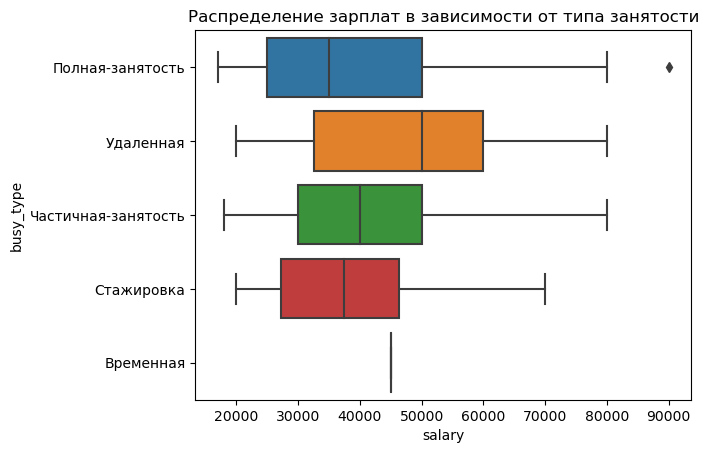

In [79]:
plt.title('Распределение зарплат в зависимости от типа занятости')
sns.boxplot(data=df, y='busy_type', x='salary', orient='h')
plt.show()

По какой-то причине удаленный тип занятости имеет наибольший оклад, попробуем найти взаимосвязь, выведем график распределения зарплат в зависимости от типа занятости и региона проживания.

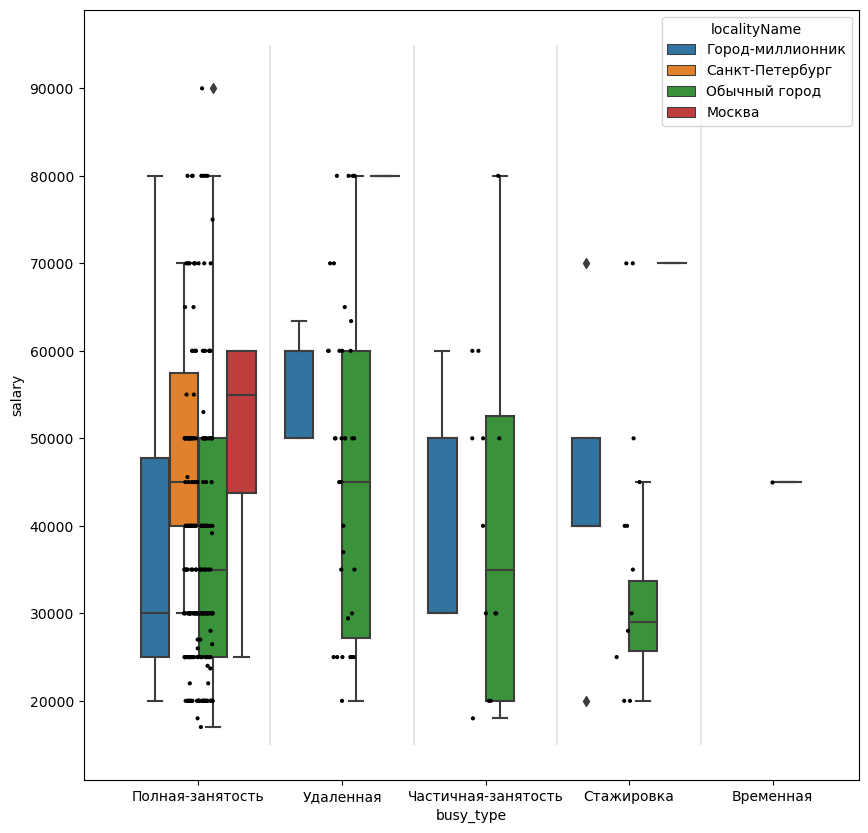

In [80]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, x='busy_type', y='salary', hue='localityName')
sns.stripplot(x='busy_type', y='salary', data=df, color='black', size=3, jitter=1)
for i in range(len(df['busy_type'].unique())-1):
    plt.vlines(i+.5, 15000, 95000, linestyles='solid', colors='gray', alpha=0.2)
plt.show()

Типы занятости временной, стажировка, частичная-занятость имеют мало записей, а также неоднозначное распределение, по которому непросто судить о зарплате

На основе этого мы не будем включать столбец в признаки для машинного обучения.

In [81]:
df.drop(['busy_type'], axis=1, inplace=True)

#### 2. Столбец business_trip

In [82]:
df['business_trip'].value_counts()

Не-готов-к-командировкам    222
Готов-к-командировкам        77
Name: business_trip, dtype: int64

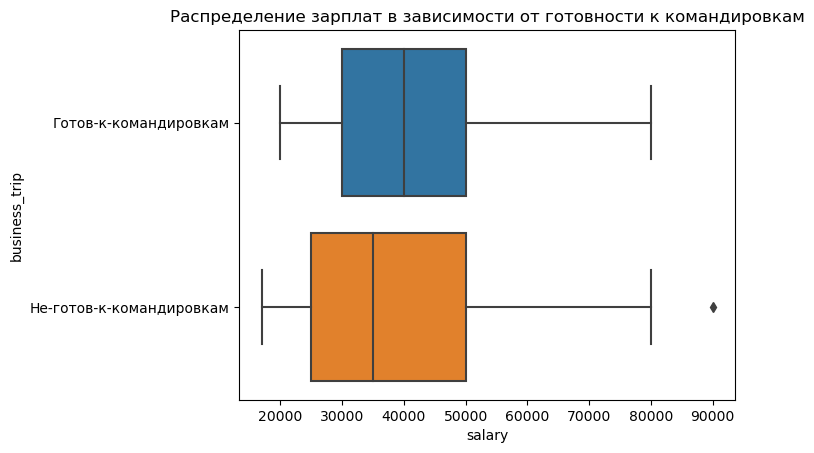

In [83]:
plt.title('Распределение зарплат в зависимости от готовности к командировкам')
sns.boxplot(data=df, x='salary', y='business_trip', orient='h')
plt.show()

Разница незначительна, с помощью теста Стьюдента можно определить есть ли статистическая значимость между распределение зарплат двух выборок. Возьмем порог значимости в 0.05

In [84]:
sample1 = df[df['business_trip']=='Готов-к-командировкам']['salary']
sample2 = df[df['business_trip']=='Не-готов-к-командировкам']['salary']

print('Дисперсия первой выборки:', np.var(sample1))
print('Дисперсия второй выборки:', np.var(sample2))

Дисперсия первой выборки: 269190976.8770452
Дисперсия второй выборки: 265200428.41841146


Дисперсия равны, значит `equal_var = True`

In [85]:
alpha = 0.05

results = stats.ttest_ind(sample1, sample2, equal_var=True)
print('pvalue =', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Зарплата при готовности к командировке -', sample1.mean())
print('Зарплата при неготовности к командировке -', sample2.mean())

pvalue = 0.006012852934869767
Отвергаем нулевую гипотезу
Зарплата при готовности к командировке - 44096.07792207792
Зарплата при неготовности к командировке - 38105.02252252252


Есть основания полагать, что при готовности к командировке зарплата будет выше.

#### 3. Столбец retraining_capability

In [86]:
df['retraining_capability'].value_counts()

Готов-к-переобучению       180
Не-готов-к-переобучению    119
Name: retraining_capability, dtype: int64

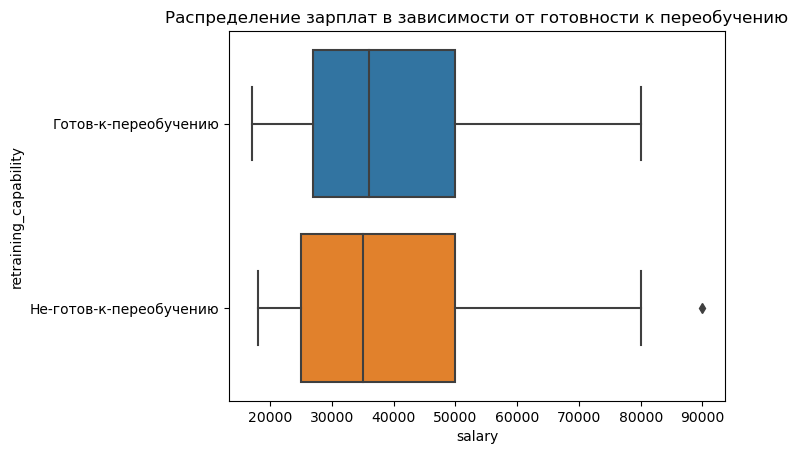

In [87]:
plt.title('Распределение зарплат в зависимости от готовности к переобучению')
sns.boxplot(data=df, x='salary', y='retraining_capability', orient='h')
plt.show()

Распределения идентичны, потому полезной информации этот признак не несет.

In [88]:
df.drop(['retraining_capability'], axis=1, inplace=True)

#### 4. Столбец additionalEducationList

In [89]:
df['additionalEducationList'].value_counts()

0    279
1     20
Name: additionalEducationList, dtype: int64

В процессе избавления данных от выбросов, дисбаланс классов усилился. Однако достаточно большая разница в зарплатах может нивелировать ее:

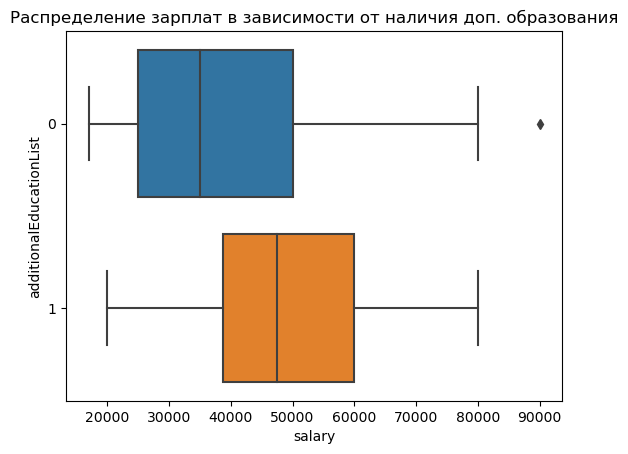

In [90]:
plt.title('Распределение зарплат в зависимости от наличия доп. образования')
sns.boxplot(data=df, x='salary', y='additionalEducationList', orient='h')
plt.show()

Несмотря на малое количество записей (7%), наличие дополнительного образования может являться неплохим маркером к увеличению зарплаты.

### Кодировка признаков

Мы имеем следующие признаки:

In [91]:
df.head()

,localityName,education,experience,salary,business_trip,fullness_rate,additionalEducationList,B_license,eng,ru,companies_exp,skills_quantity,professionSphere
0,Город-миллионник,Среднее-профессиональное,2,30000,Готов-к-командировкам,79,0,0,1,1,2,0,Другая
1,Санкт-Петербург,Среднее,14,30000,Не-готов-к-командировкам,69,0,0,0,2,3,0,InformationTechnology
2,Обычный город,Среднее,0,25000,Не-готов-к-командировкам,73,0,0,1,0,1,5,InformationTechnology
3,Город-миллионник,нет,0,39157,Не-готов-к-командировкам,53,0,0,0,1,0,0,InformationTechnology
4,Обычный город,Среднее-профессиональное,0,30000,Не-готов-к-командировкам,71,0,0,0,2,0,5,InformationTechnology


Следующие признаки необходимо закодировать:
* localityName
* education
* busy_type
* business_trip
* retraining_capability
* professionSphere

Кодировка будет проходить по принципу ordinal encoding.

In [92]:
encoder = OrdinalEncoder()
categorical_columns = ['localityName', 'education', 'business_trip', 'additionalEducationList', 
                       'B_license', 'eng', 'ru', 'professionSphere', 'companies_exp']
df_oe = df.copy()
df_oe[categorical_columns] = encoder.fit_transform(df[categorical_columns])

df_oe.head()

,localityName,education,experience,salary,business_trip,fullness_rate,additionalEducationList,B_license,eng,ru,companies_exp,skills_quantity,professionSphere
0,0.0,3.0,2,30000,0.0,79,0.0,0.0,1.0,1.0,2.0,0,5.0
1,3.0,2.0,14,30000,1.0,69,0.0,0.0,0.0,2.0,3.0,0,3.0
2,2.0,2.0,0,25000,1.0,73,0.0,0.0,1.0,0.0,1.0,5,3.0
3,0.0,4.0,0,39157,1.0,53,0.0,0.0,0.0,1.0,0.0,0,3.0
4,2.0,3.0,0,30000,1.0,71,0.0,0.0,0.0,2.0,0.0,5,3.0


<AxesSubplot:>

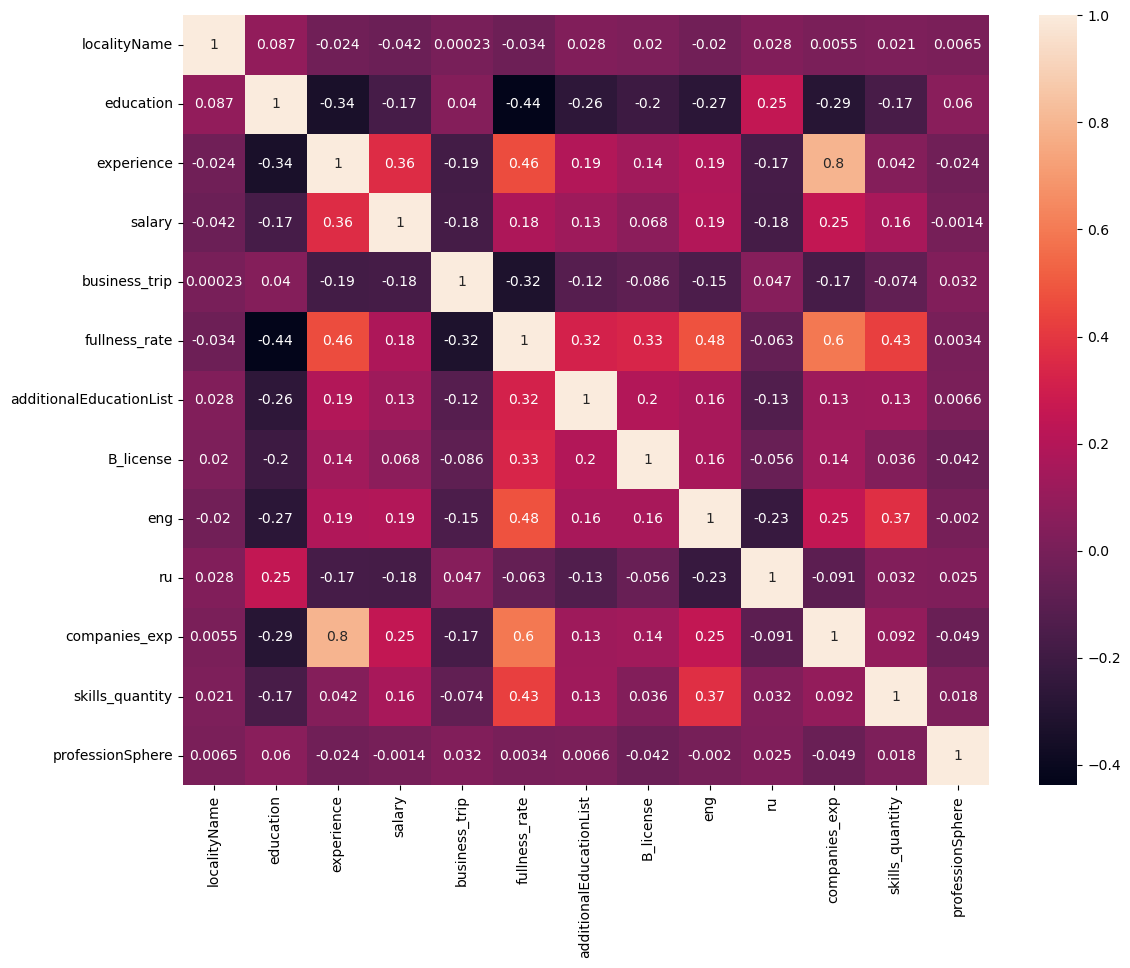

In [93]:
plt.figure(figsize=(13,10))
sns.heatmap(df_oe.corr(method='spearman'), annot=True)

При отборе признаков мы должны учитывать корреляцию не только с целевым признаком, но и между всеми остальными признаками. В данном случае experience прямо коррелирует с companies_exp, в которых работал человек. Более того companies_exp сильно коррелирует с fullness_rate.

А fullness_rate вцелом имеет связь с многими переменными, особенно с признаками английского языка, уровня образования и количества навыков.

Поэтому мы примем решение об **удалении столбца companies_exp и fullness_rate**.

In [94]:
df_oe.drop(['companies_exp', 'fullness_rate'], axis=1, inplace=True)

### Разбиение на выборки

Пришло время делить таблицу на выборки. Инструменты, которыми мы будем пользоваться в дальнейшем будут подбирать гиперпараметры методом bootstrap, нам не обязательно создавать валидационную выборку. Разделим на тренировочную и тестовую выборки соотношением **3:1**

In [95]:
def get_samples(table, target, test_size):
    X = table.drop([target], axis=1)
    y = table[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=582002)

    return X_train, X_test, y_train, y_test

In [96]:
X_train, X_test, y_train, y_test = get_samples(df_oe, 'salary', .25)

### Стандартизация

Стандартизация нужна чтобы привести все численные столбцы к одной размерности, для этого у нас есть `StandardScaler()`. Мы обучим его на тренировочных признаках и применим к тренировочным и тестовым.

In [97]:
def standardize(scaler, table, columns):
    table = table.copy()
    table[columns] = scaler.transform(table[columns])
    return table

In [98]:
numeric_columns = ['experience',
                   'skills_quantity']

scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])

X_train_scaled = standardize(scaler, X_train, numeric_columns)

X_test_scaled = standardize(scaler, X_test, numeric_columns)

In [99]:
X_train_scaled.head()

,localityName,education,experience,business_trip,additionalEducationList,B_license,eng,ru,skills_quantity,professionSphere
274,2.0,3.0,-0.611883,1.0,0.0,0.0,1.0,2.0,1.341567,3.0
224,0.0,3.0,0.075144,0.0,0.0,0.0,1.0,0.0,-0.627705,3.0
71,2.0,0.0,1.449197,0.0,1.0,0.0,1.0,2.0,0.947712,3.0
326,2.0,3.0,-0.611883,1.0,0.0,0.0,1.0,0.0,-0.627705,5.0
8,2.0,0.0,2.479738,0.0,0.0,1.0,0.0,1.0,-0.627705,2.0


In [100]:
X_test_scaled.head()

,localityName,education,experience,business_trip,additionalEducationList,B_license,eng,ru,skills_quantity,professionSphere
149,0.0,4.0,2.136224,1.0,0.0,0.0,0.0,1.0,0.160003,0.0
229,2.0,0.0,-0.611883,1.0,0.0,0.0,0.0,1.0,-0.627705,3.0
9,0.0,0.0,1.792711,1.0,0.0,0.0,1.0,1.0,-0.627705,3.0
129,2.0,2.0,-0.611883,1.0,0.0,0.0,0.0,1.0,-0.627705,3.0
69,2.0,0.0,0.418657,1.0,1.0,0.0,2.0,0.0,2.523130,3.0


## Прогнозирование

Для прогнозирование зарплаты мы будем использовать следующие модели:
1. RandomForest
2. CatBoost
3. LinearRegression

Метрики, которые будем оценивать:
1. R2
2. MAE
3. RMSE

Смотреть на результат обучения будем методом кросс валидации. 

In [101]:
def cross_validate_results(model):
    cv = cross_validate(model, 
                        X_train_scaled, 
                        y_train, 
                        scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
                        return_train_score=True)
    
    for k, v in dict({'Тренировочная':'train', 'Валидационная':'test'}).items():
        r2 = cv[f'{v}_r2'].mean()
        rmse = cv[f'{v}_neg_root_mean_squared_error'].mean()
        mae = cv[f'{v}_neg_mean_absolute_error'].mean()
        
        print(f'{k}')
        print('r2 =', r2)
        print('rmse =', rmse)
        print('mae =', mae, '\n')

Анализ значимости признаков будет осуществляться атрибутом `feature_importances_`, который доступен моделям RandomForest и CatBoost.

### RandomForestRegressor

Поиск параметров будет осуществлять optuna, как наиболее быстрый инструмент из доступных. Тем более мы можем оптимизировать модель под метрику R2.

In [102]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [103]:
RANDOM_STATE = 582002

params = {'n_estimators': IntDistribution(4, 50),
          'max_depth': IntDistribution(3,15),
          'min_samples_leaf': IntDistribution(2, 16),
          'min_samples_split': IntDistribution(2, 16),
          'max_features': CategoricalDistribution(['log2', 'sqrt']),
          'bootstrap': CategoricalDistribution(['True', 'False'])}

search = OptunaSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_distributions = params,
    scoring='r2',
    n_trials=1000,
    timeout=600,
    random_state=RANDOM_STATE)

search.fit(X_train_scaled, y_train)

print('best r2 =', search.best_score_)
model = search.best_estimator_

C:\Users\79283\AppData\Local\Temp\ipykernel_15308\3936595683.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(


best r2 = 0.16911674180539854


<AxesSubplot:>

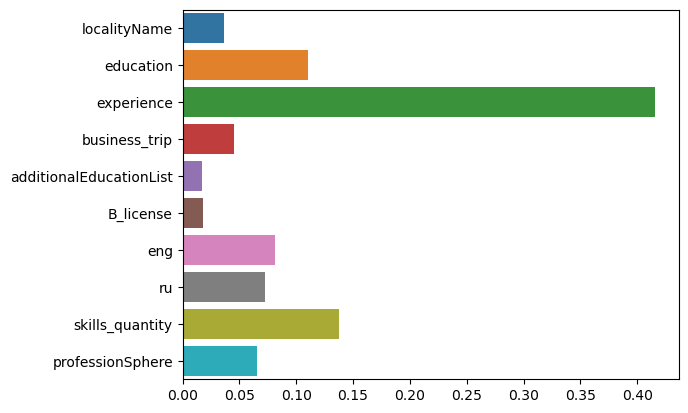

In [104]:
sns.barplot(x=model.feature_importances_, y=X_train_scaled.columns)

In [105]:
cross_validate_results(model)

Тренировочная
r2 = 0.3530174208283684
rmse = -13880.674988932693
mae = -11284.068847760476 

Валидационная
r2 = 0.16911674180539854
rmse = -15568.597809758849
mae = -12628.765737693968 



### CatBoost

Для подбора параметров у catboost есть свой метод `grid_search()`. Для этой модели мы будем оптимизировать 

In [106]:
grid = {'iterations': [100, 300, 500],
        'learning_rate': [0.03, 0.06, 0.1, 0.3],
        'depth': [3, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

model2 = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
grid_search_results = model2.grid_search(grid, verbose=False,
                                        X=X_train_scaled,
                                        y=y_train,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<AxesSubplot:>

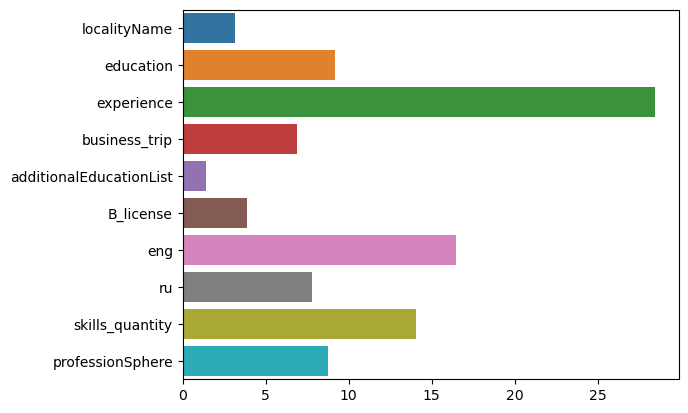

In [107]:
sns.barplot(x=model2.feature_importances_, y=X_train_scaled.columns)

In [108]:
cross_validate_results(model2)

Тренировочная
r2 = 0.7096380046829978
rmse = -9286.123579795361
mae = -6922.2097169188055 

Валидационная
r2 = 0.09398091865139575
rmse = -16197.406645422907
mae = -13023.019456270347 



### LinearRegression

In [109]:
model3 = LinearRegression()

cross_validate_results(model3)

Тренировочная
r2 = 0.23756685209192
rmse = -15071.940376020211
mae = -12055.913375940861 

Валидационная
r2 = 0.1438626713891895
rmse = -15786.563311150641
mae = -12758.488473186857 



### Вывод

По итогу мы имеем следующие результаты:

In [110]:
columns = [('RandomForest', 'train'), ('RandomForest', 'val'),
    ('CatBoost', 'train'), ('CatBoost', 'val'),
    ('LinearRegression', 'train'), ('LinearRegression', 'val')]
values = [[ 11284, 12628, 6922, 13023, 12055, 12758],
     [ 13868, 15539, 9288, 16197, 15071, 15786],
     [0.393, 0.169, 0.710, 0.093, 0.238, 0.144]]
index = ['mae','rmse','r2']
tbl = pd.DataFrame(values, index=index, columns=columns)
tbl.columns = pd.MultiIndex.from_tuples(tbl.columns, names=[None,None])

display(tbl)

RandomForest            CatBoost            LinearRegression           
            train        val    train        val            train        val
mae     11284.000  12628.000  6922.00  13023.000        12055.000  12758.000
rmse    13868.000  15539.000  9288.00  16197.000        15071.000  15786.000
r2          0.393      0.169     0.71      0.093            0.238      0.144

Метрику RMSE, как и MAE, проще оценивать через R2. При идеальной работе модели R2 = 1, при R2 = 0 модель прогнозирует всем записям среднее значение, а при отрицательном значении - модель дает совсем недостоверный результат. 

По результатам метрики R2, мы наблюдаем, что CatBoost переобучися на тренировочной выборке, для решения этой проблемы можно было бы использовать детектор переобучения - параметр `early_stopping`, однако для этого нам нужна третья выборка - валидационная. 

LinearRegression не переобучен, при этом имеет менее точные результаты по сравнению с RandomForest в метрике R2.

Метрики MAE и RMSE указывают на среднее отклонение от истинного результата. Чем больше разница между RMSE и MAE, тем слабее модель выявляла крайние значения зарплат. По всем моделям это значение примерно одинаково.

По результатам обучения мы выберем **RandomForest**.

## Тестирование

In [111]:
predicts = model.predict(X_test_scaled)
print('r2 =', r2_score(y_test, predicts))
print('rmse =', mean_squared_error(y_test, predicts)**0.5)
print('mae =', mean_absolute_error(y_test, predicts))

r2 = 0.11482224004141406
rmse = 13123.202478380166
mae = 10595.080963851124


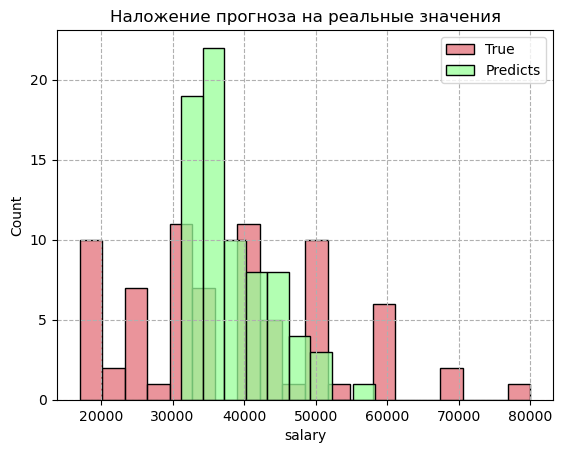

In [112]:
plt.title('Наложение прогноза на реальные значения')
plt.grid(linestyle='--')
sns.histplot(y_test, color='#E4717A', bins=20, label='True')
sns.histplot(predicts, color='#99FF99', binwidth=3000, label='Predicts')
plt.legend()

## Выводы

В ходе выполнения тестового задания был проведен анализ резюме программистов, на основе которых необходимо было обучить модель прогнозирующую ожидаемую зарплату.

В ходе анализа мы рассмотрели распределения всех признаков, а так же распределения признаков по отношению к зарплате. И выяснили следующее о зарплатах:

1. Основная масса зарплат лежит в диапазоне от 20000 до 60000
2. Размах зарплат у людей с водительской лицензией немного больше чем у людей без лицензии
3. С увеличением уровня знания английского и другого европейского языка - зарплата заметно растет. Человек с базовым пониманием английского в среднем рассчитывает на 10000 рублей больше чем незнающий языка, то же самое отношение у свободного носителя к человеку с базовым пониманием. Люди, которые не указали русский язык в резюме, имеют зарплату больше чем те кто указал. Вероятно, если человек знает второй язык не станет указывать русский язык.
4. Минимальные зарплаты получают люди, неимеющие опыта.
5. Количество навыков немного коррелирует с зарплатой.
6. Зарплата зависит от размаха города. Чем крупнее город тем больше зарплата: Москва **=>** Санкт-Петербург **=>** миллионник **=>** обычный
7. Готовность к командировке может увеличить зарплату в среднем на 5000.
8. Готовность к переобучению абсолютно никак не влияет на зарплату.
9. Наличие дополнительного образование может немного увеличить зарплату.

Мы обучили модели RandomForest, CatBoost и LinearRegression и на основании результатов кросс валидации **выбрали RandomForest** в качестве лучшей. Она не слишком переобучена как CatBoost и более точна чем LinearRegression. Оценивали по метрикам R2, RMSE и MAE.

**Результат тестирования:<br>
R2 = 0.115<br>
RMSE = 13123<br>
MAE = 10595**

Итоговая модель имеет низкое качество, но все еще лучше чем прогнозирование по среднему значению.

Модель имеет следующие параметры:

In [113]:
model

RandomForestRegressor(bootstrap='True', max_depth=5, max_features='log2',
                      min_samples_leaf=2, min_samples_split=11, n_estimators=35,
                      random_state=582002)

Следующие признаки больше всего повлияли на прогноз зарплаты:

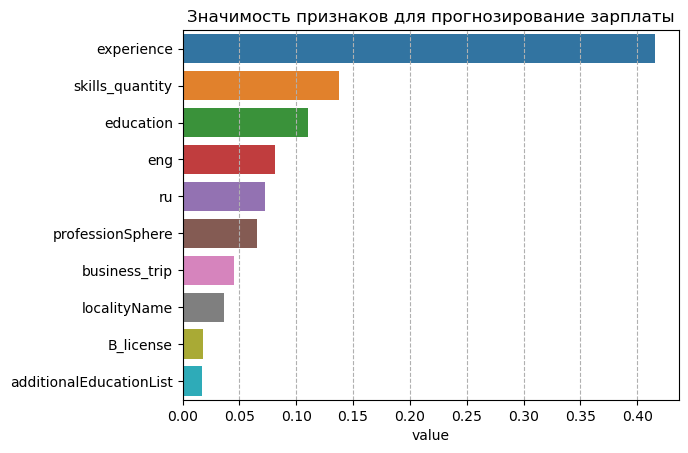

In [114]:
best_features = pd.DataFrame({'value':model.feature_importances_},
                              index=X_train_scaled.columns)
best_features = best_features.sort_values(by='value', ascending=False)

plt.title('Значимость признаков для прогнозирование зарплаты')
sns.barplot(data=best_features,
            x='value', 
            y=best_features.index, 
            orient='h')
plt.grid(linestyle='--', axis='x')

В ходе предобработки данных мы устранили пропуски, удалили более половины неинформативных столбцов, удалили выбросы в распределениях. Создали 9 признаков, 5 из которых приняли для обучения, что положительно, но не в достаточной мере повлияло на качество модели. 